In [101]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
import eulerN as arch 
import torch
from torch import nn

def waterfall(data, filename=None, drf=None, cmap='magma', levels=15, **tau_f_kwargs):
    n, m = data.shape
    x, y = np.linspace(1, n, num=n), np.linspace(1, m, num=m) * tau_f_kwargs['dt'] / tau_f_kwargs['Lyapunov_time']
    if drf is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        im = ax.contourf(x, y, data.T, levels=levels, cmap=cmap)
        fig.colorbar(im, ax=[ax])
    else:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(121)
        ax1 = fig.add_subplot(122)
        im = ax.contourf(x, y, data.T, levels=levels, cmap=cmap)
        z = drf.multistep_forecast(data[:, 0], m).cpu().numpy()
        print(z.shape)
        ax1.contourf(x, y, z.T, levels=levels, cmap=cmap)
        # ax1.set_ylabel(r'$t/T^{\Lambda_1}$')
        ax1.set_title(r'Forecast')
        fig.colorbar(im, ax=[ax, ax1])
        ax1.set_yticks([])
    ax.set_ylabel(r'$t/T^{\Lambda_1}$')
    ax.set_title(r'Truth')
    if filename is not None:
        plt.savefig(f'../data/plots/{filename}.png', bbox_inches='tight', dpi=300)
    plt.show()   

In [96]:
# Waterfall for best L96 model
L0, L1 = 0.4, 3.5
D_r, B = 8192, 1
training_points = 100000
Uo = torch.tensor(np.load(f'../data/L96-trajectories/train{B}.npy'))
Vo = torch.tensor(np.load(f'../data/L96-trajectories/test.npy'))
beta_data = pd.read_csv(f'../data/L96/EulerN/beta/beta.csv')
beta = float(beta_data[beta_data['D_r']==D_r]['beta'].iloc[0])
tau_f_kwargs = {'error_threshold' : 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}
drf_args = [D_r, B, L0, L1, Uo, beta, 'EulerN', f"../data/EulerN/L96/D_r-{D_r}", False]
drf = arch.DeepRF(*drf_args)
data = pd.read_csv(f'../data/L96/EulerN/D_r-{D_r}/batch_data.csv')
best_index = np.argmax(data['tau_f_nmse'])
model_seed = int(data['model_seed'].to_numpy()[best_index])
train_index = int(data['train_index'].to_numpy()[best_index])
test_index = int(data['test_index'].to_numpy()[best_index])
train = Uo[:, train_index: train_index + training_points]
drf.learn(train, model_seed)

(40, 300)


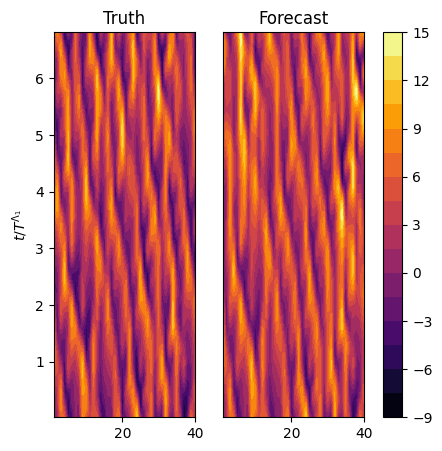

In [102]:
trajectory = Vo[test_index, :, :300]
waterfall(trajectory, filename='L96-waterfall', drf=drf, cmap='inferno', levels=20, **tau_f_kwargs)

In [51]:
# Waterfall for best L96 model
L0, L1 = 0.4, 3.5
D_r, B = 8192, 1
training_points = 100000
Uo = torch.tensor(np.load(f'../data/KS-trajectories/train{B}.npy'))
Vo = torch.tensor(np.load(f'../data/KS-trajectories/test.npy'))
# beta_data = pd.read_csv(f'../data/L96/EulerN/beta/beta.csv')
# beta = float(beta_data[beta_data['D_r']==D_r]['beta'].iloc[0])
# tau_f_kwargs = {'error_threshold' : 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}
# drf_args = [D_r, B, L0, L1, Uo, beta, 'EulerN', f"../data/EulerN/L96/D_r-{D_r}", False]
# drf = arch.DeepRF(*drf_args)
# data = pd.read_csv(f'../data/L96/EulerN/D_r-{D_r}/batch_data.csv')
# best_index = np.argmax(data['tau_f_nmse'])
# model_seed = int(data['model_seed'].to_numpy()[best_index])
# train_index = int(data['train_index'].to_numpy()[best_index])
# test_index = int(data['test_index'].to_numpy()[best_index])
# train = Uo[:, train_index: train_index + training_points]
# drf.learn(train, model_seed)

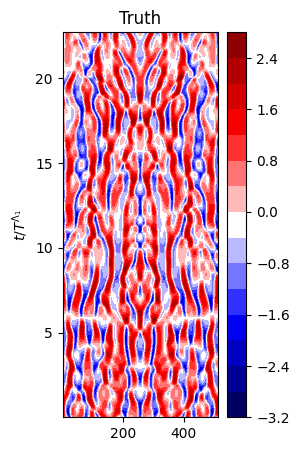

In [61]:
trajectory = Vo[np.random.randint(25), :, :1000]
# trajectory = Uo[:, train_index: train_index + 300]
waterfall(trajectory, cmap='seismic', levels=1, **tau_f_kwargs)

In [98]:
data.iloc[best_index]

l              1.940000e+02
model_seed     7.220698e+07
train_index    6.940200e+04
test_index     2.720000e+02
tau_f_nmse     4.789700e+00
tau_f_se       4.903200e+00
nmse           3.094647e-01
se             2.499493e-01
Name: 194, dtype: float64